# Binary Outcomes

In [1]:
using HypothesisTests, CSV
using AnovaGLM, Effects, MLJ
include("pubh.jl");

In [2]:
set_default_plot_size(15cm, 12cm)
@rlibrary readr
@rimport pubh

In [3]:
#| output: false
R"""
library(pubh)
""";

┌ Warning: RCall.jl: Loading required package: emmeans
│ Loading required package: ggformula
│ Loading required package: ggplot2
│ Loading required package: scales
│ Loading required package: ggridges
│ 
│ New to ggformula?  Try the tutorials: 
│ 	learnr::run_tutorial("introduction", package = "ggformula")
│ 	learnr::run_tutorial("refining", package = "ggformula")
│ Loading required package: gtsummary
│ Loading required package: huxtable
│ 
│ Attaching package: ‘huxtable’
│ 
│ The following object is masked from ‘package:gtsummary’:
│ 
│     as_flextable
│ 
│ The following object is masked from ‘package:scales’:
│ 
│     number_format
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     theme_grey
│ 
│ Loading required package: magrittr
└ @ RCall /Users/josie/.julia/packages/RCall/YrsKg/src/io.jl:172


## Confidence Intervals for Proportions

For the first section, we will use the `Bernard` dataset. We will calculate the proportion of sepsis patients who were classified as non-white and will compare this to a reference value. It is important to note that the non-white category is used here because it is classified as 1, which is considered the *success* in the binomial setting.

In [4]:
bernard = rcopy(R"pubh::Bernard")
bernard |> schema

┌──────────┬────────────────────────────┬──────────────────────────────────┐
│ names    │ scitypes                   │ types                            │
├──────────┼────────────────────────────┼──────────────────────────────────┤
│ id       │ Continuous                 │ Float64                          │
│ treat    │ Multiclass{2}              │ CategoricalValue{String, UInt32} │
│ race     │ Multiclass{3}              │ CategoricalValue{String, UInt32} │
│ fate     │ Multiclass{2}              │ CategoricalValue{String, UInt32} │
│ apache   │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
│ o2del    │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
│ followup │ Continuous                 │ Float64                          │
│ temp0    │ Continuous                 │ Float64                          │
│ temp10   │ Union{Missing, Continuous} │ Union{Missing, Float64}          │
└──────────┴────────────────────────────┴──────────────────────────────────┘

As `race` has three categories (levels), we will generate a new race variable (which we will call `Race`) that collapses two of the categories (white and non-white).

In [5]:
tabulate(bernard, :race)

                 | Freq. | Percent |  Cum.   
---------------------------------------------
           White |   293 |  64.396 |  64.396 
African American |   130 |  28.571 |  92.967 
           Other |    32 |   7.033 | 100.000 
---------------------------------------------
           Total |   455 | 100.000 |         


In [6]:
bernard.Race = recode(
  bernard.race, 
  "African American" => "Non-White", 
  "Other" => "Non-White"
)

tabulate(bernard, :Race)

          | Freq. | Percent |  Cum.   
--------------------------------------
    White |   293 |  64.396 |  64.396 
Non-White |   162 |  35.604 | 100.000 
--------------------------------------
    Total |   455 | 100.000 |         


In [7]:
r3.(BinomialTest(162, nrow(bernard)) |> confint)

(0.312, 0.402)

## **One-Sample Hypothesis Tests for Proportions**

Sometimes, we would like to test if the proportion of our sample is statistically different from a reference (one-sample tests). For example, let's say that from the census you know that 40% of the population is non-white. Did your study have a significantly lower proportion of non-whites? The 95% CI that we estimated previously include our reference value. If we would like to include a $p$-value in our report, we perform a one-sample test for proportions. The first argument of `BinomialTest` is the number of successes (events), the second argument is the total number of observations and the third argument is the probability of success used for the null hypothesis.

In [8]:
BinomialTest(162, nrow(bernard), 0.4)

Binomial test
-------------
Population details:
    parameter of interest:   Probability of success
    value under h_0:         0.4
    point estimate:          0.356044
    95% confidence interval: (0.312, 0.402)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0608

Details:
    number of observations: 455
    number of successes:    162


## Case-control Studies

::: callout-tip
## Example

We will look at a case-control study looking at several potential risk factors on presenting oesophageal cancer.
:::

In [9]:
cancer = read_rds("data/cancer.rds") |> rcopy
cancer |> head

Row,age,alcohol,tobacco,status
,Cat…,Cat…,Cat…,Cat…
1,25-34,40-79,0-9,Control
2,25-34,0-39,0-9,Control
3,25-34,40-79,30+,Control
4,25-34,40-79,10-19,Control
5,25-34,40-79,0-9,Control


Let's take a look at the frequency table of `alcohol`:

In [10]:
tabulate(cancer, :alcohol)

       | Freq. | Percent |  Cum.   
-----------------------------------
  0-39 |   415 |  42.564 |  42.564 
 40-79 |   355 |  36.410 |  78.974 
80-119 |   138 |  14.154 |  93.128 
  120+ |    67 |   6.872 | 100.000 
-----------------------------------
 Total |   975 | 100.000 |         


::: callout-caution
## Exercise

Create a new categorical variable, named `etoh` where your reference represents `0-39` and everything else is `40+`
:::

In [11]:
#| code-fold: true
cancer.etoh = recode(
  cancer.alcohol, 
  "40-79" => "40+", 
  "80-119" => "40+", 
  "120+" => "40+"
)

tabulate(cancer, :etoh)

      | Freq. | Percent |  Cum.   
----------------------------------
 0-39 |   415 |  42.564 |  42.564 
  40+ |   560 |  57.436 | 100.000 
----------------------------------
Total |   975 | 100.000 |         


Now, we can look at the corresponding cross-tabulation between outcome and exposure.

::: callout-important
For the tabulation, the *exposure* goes in the rows while the *outcome* goes in the columns.
:::

In [12]:
tabulate(cancer, :etoh, :status)

     |       |     status     |       
     |       | Case | Control | Total 
--------------------------------------
etoh |  0-39 |   29 |     386 |   415 
     |   40+ |  171 |     389 |   560 
--------------------------------------
     | Total |  200 |     775 |   975 


We would like to report *measures of association* for epidemiological studies. The function `contingency` from the `pubh` package, allows us to do that.

In [13]:
pubh.contingency(
  @formula(status ~ etoh),
  data = cancer,
  method = "case.control"
  )

         Outcome
Predictor Case Control
     40+   171     389
     0-39   29     386

             Outcome +    Outcome -      Total                       Odds
Exposed +          171          389        560        0.44 (0.37 to 0.53)
Exposed -           29          386        415        0.08 (0.05 to 0.11)
Total              200          775        975        0.26 (0.22 to 0.30)

Point estimates and 95% CIs:
-------------------------------------------------------------------
Exposure odds ratio                            5.85 (3.85, 8.89)
Attrib fraction (est) in the exposed (%)      82.88 (73.78, 89.14)
Attrib fraction (est) in the population (%)   70.89 (58.94, 79.36)
-------------------------------------------------------------------
Uncorrected chi2 test that OR = 1: chi2(1) = 81.060 Pr>chi2 = <0.001
Fisher exact test that OR = 1: Pr>chi2 = <0.001
 Wald confidence limits
 CI: confidence interval



	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 79.623, df = 1, p-value < 2.2e-16



RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 79.623, df = 1, p-value < 2.2e-16



::: callout-caution
The previous code only runs well in `Jupyter` notebooks. Anywhere else, it is important to add: `|> rcopy` to the end of the command. For `Jupyter` notebooks, adding `|> rcopy` also works, it just gives further output that is irrelevant.
:::

::: callout-caution
`R` function `contingency` does not work within `Pluto` notebooks.
:::

It is also possible to make calculations, using the information from a standard two-by-two table (i.e., as an immediate command) with `contingency2`.

:::{.callout-important}
When using `contingency2` it is important that numbers are given in the right order. For the exposure, first the exposed and then the unexposed; for the outcome, first cases and then controls. We can use `epitab` to reverse the order of *rows*, *columns* or *both*
:::

In [14]:
@rlibrary epitools
epitable(cancer.etoh, cancer.status, rev="both")

RObject{IntSxp}
         Outcome
Predictor Case Control
     40+   171     389
     0-39   29     386


In [15]:
pubh.contingency2(171, 389, 29, 386, method = "case.control")


    Yes  No
Yes 171 389
No   29 386

             Outcome +    Outcome -      Total                       Odds
Exposed +          171          389        560        0.44 (0.37 to 0.53)
Exposed -           29          386        415        0.08 (0.05 to 0.11)
Total              200          775        975        0.26 (0.22 to 0.30)

Point estimates and 95% CIs:
-------------------------------------------------------------------
Exposure odds ratio                            5.85 (3.85, 8.89)
Attrib fraction (est) in the exposed (%)      82.88 (73.78, 89.14)
Attrib fraction (est) in the population (%)   70.89 (58.94, 79.36)
-------------------------------------------------------------------
Uncorrected chi2 test that OR = 1: chi2(1) = 81.060 Pr>chi2 = <0.001
Fisher exact test that OR = 1: Pr>chi2 = <0.001
 Wald confidence limits
 CI: confidence interval

	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 79.623, df = 1, p-value < 2.2e-16



RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 79.623, df = 1, p-value < 2.2e-16



::: callout-warning
## Question

What is your conclusion from the analysis?
:::

::: callout-note
## Answer

The odds ratio of developing oesophageal cancer in subjects who were categorised as consumers of alcohol (40 g or more per day) is 5.85 (95% CI: 3.85, 8.89) against those categorised as non-consumers (less than 40 g/day). Therefore, the association between alcohol consumption and development of oesophageal cancer was found to be statistically significant (*p* \< 0.001, $\chi^2$ test)
:::

### **Confounding: Stratification**

Age is a variable that could act as a confounder in our estimation. We can use the Mantel-Haenszel approach to control for the effect of age.

In [16]:
pubh.mhor(@formula(status ~ age/etoh), data=cancer) |> rcopy


                        OR Lower.CI Upper.CI Pr(>|z|)
age25-34:etoh40+ 787866.90     0.00      Inf    0.979
age35-44:etoh40+      6.90     0.85    56.27    0.071
age45-54:etoh40+     38.50     5.19   285.86  < 0.001
age55-64:etoh40+      4.61     2.32     9.18  < 0.001
age65-74:etoh40+      5.22     2.43    11.20  < 0.001
age75+:etoh40+        6.47     1.55    26.93     0.01

                          Common OR Lower CI Upper CI Pr(>|z|)
Cochran-Mantel-Haenszel:        6.7     4.28    10.51  < 0.001

Test for effect modification (interaction): p =  0.2265 
 


The *formula* used in `mhor` uses the syntax: `outcome ~ strata/exposure`, both the outcome and the exposure have to be binary (factors with two levels). The confounding variable (`strata`) has to be categorical (a factor) and can have more than two levels.

::: callout-note
The test of interaction reported at the end of the output is testing the null hypothesis that the OR is the same for all groups. If *p* \< 0.05, we would find statistical evidence that the effect is not the same (evidence of an interaction).
:::

::: callout-important
## Interpretation

The output displays the effect of alcohol (`etoh`, consuming $\geq$ 40 g/day, against consuming \< 40 g/day) for each stratum (level) of `age` on developing oesophageal cancer (`status`, case vs. control). For example, for the age group of 55 to 64 years old, we can infer that subjects who consume 40 g or more of alcohol per day, have an OR = 4.61 (95% CI: 2.32, 9.18) of developing oesophageal cancer, when compared to subjects who consume less than 40 g alcohol per day.

The overall (pool) OR, of alcohol consumption on the development of oesophageal cancer, adjusted by age, is 6.70 (95% CI: 4.28, 10.51, *p* \< 0.001).

There was no evidence of different effects of alcohol for different age groups (*p* = 0.227).
:::

::: callout-warning
## Question

Was age a confounder?
:::

::: callout-note
## Answer

Yes! The raw OR was 5.85 when we control for age the actual effect of alcohol is an OR = 6.70 (95% CI: 4.28, 10.51).
:::

Let's take have a deeper look at the number of cases per exposure group (`etoh`), stratified by age and then, in particular, in the first age group.

In [17]:
tabulate(@subset(cancer, :age == "25-34"), :etoh, :status)

     |       |     status     |       
     |       | Case | Control | Total 
--------------------------------------
etoh |  0-39 |      |      61 |    61 
     |   40+ |    1 |      54 |    55 
--------------------------------------
     | Total |    1 |     115 |   116 


::: callout-warning
## Question

What is your main observation?
:::

::: callout-note
## Answer

There were no cancer cases for the younger age group of non-alcohol consumers (\< 40 g/day) and, thus, the OR cannot be calculated for that age group.
:::

We can combine the observations of the first two levels on a single one with `recode`.

First take a look at the original levels:

In [18]:
levels(cancer.age)

6-element Vector{String}:
 "25-34"
 "35-44"
 "45-54"
 "55-64"
 "65-74"
 "75+"

In [19]:
cancer.Age = recode(
  cancer.age, 
  "25-34" => "25-44", 
  "35-44" => "25-44"
);

In [20]:
levels!(cancer.Age, ["25-44", "45-54", "55-64", "65-74", "75+"]);

In [21]:
pubh.mhor(@formula(status ~ Age/etoh), data = cancer) |> rcopy


                    OR Lower.CI Upper.CI Pr(>|z|)
Age25-44:etoh40+  8.60     1.08    68.66    0.042
Age45-54:etoh40+ 38.50     5.19   285.86  < 0.001
Age55-64:etoh40+  4.61     2.32     9.18  < 0.001
Age65-74:etoh40+  5.22     2.43    11.20  < 0.001
Age75+:etoh40+    6.47     1.55    26.93     0.01

                          Common OR Lower CI Upper CI Pr(>|z|)
Cochran-Mantel-Haenszel:       6.74      4.3    10.56  < 0.001

Test for effect modification (interaction): p =  0.1543 
 


## Cohort Studies

::: callout-tip
## Example

We will look at the effect of the smoking status of mothers on low birth weights of the babies.
:::

In [22]:
birthwt = read_rds("data/birthwt.rds") |> rcopy
birthwt |> schema

┌───────┬───────────────┬──────────────────────────────────┐
│ names │ scitypes      │ types                            │
├───────┼───────────────┼──────────────────────────────────┤
│ low   │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ age   │ Count         │ Int64                            │
│ lwt   │ Continuous    │ Float64                          │
│ race  │ Multiclass{3} │ CategoricalValue{String, UInt32} │
│ smoke │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ ptl   │ Count         │ Int64                            │
│ ht    │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ ui    │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ ftv   │ Count         │ Int64                            │
│ bwt   │ Count         │ Int64                            │
│ Race  │ Multiclass{2} │ CategoricalValue{String, UInt32} │
└───────┴───────────────┴──────────────────────────────────┘


Let's take a look at the contingency table for the exposure (`smoke`) and the outcome (`low`).

In [23]:
tabulate(birthwt, :smoke, :low)

      |            |    low    |       
      |            | No  | Yes | Total 
---------------------------------------
smoke | Non-smoker |  86 |  29 |   115 
      |     Smoker |  44 |  30 |    74 
---------------------------------------
      |      Total | 130 |  59 |   189 


For a cohort study, we use relative risk (risk ratio) as the measure of association which is the default for both `contingency` and `contingency2`.

In [24]:
#| scrolling: true
pubh.contingency(@formula(low ~ smoke), data=birthwt)

            Outcome
Predictor    Yes No
  Smoker      30 44
  Non-smoker  29 86

             Outcome +    Outcome -      Total                 Inc risk *
Exposed +           30           44         74     40.54 (29.27 to 52.59)
Exposed -           29           86        115     25.22 (17.58 to 34.17)
Total               59          130        189     31.22 (24.69 to 38.35)

Point estimates and 95% CIs:
-------------------------------------------------------------------
Inc risk ratio                                 1.61 (1.06, 2.44)
Inc odds ratio                                 2.02 (1.08, 3.78)
Attrib risk in the exposed *                   15.32 (1.61, 29.04)
Attrib fraction in the exposed (%)            37.80 (5.47, 59.07)
Attrib risk in the population *                6.00 (-4.33, 16.33)
Attrib fraction in the population (%)         19.22 (-0.21, 34.88)
-------------------------------------------------------------------
Uncorrected chi2 test that OR = 1: chi2(1) = 4.924 Pr>chi2 =

RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  dat
X-squared = 4.2359, df = 1, p-value = 0.03958



::: callout-warning
## Question

Is mother's smoking status associated with an increased risk of low birth weight? Support your answer.
:::

::: callout-note
## Answer

Yes, it is. Babies born from mothers who were smokers were significantly more likely to have a low birth weight than babies born from non-smoker mothers ($p$ = 0.040, $\chi^2$-test). The relative risk of having low birth weight between babies from smoking mothers over non-smoking ones was 1.61 (95\% CI: 1.06, 2.44).
:::

## Tests for Association and Linear Trend

::: callout-tip
## Example

A cross-sectional study looked at the association between obesity and a biopsy resulting from mammography screening. The classes of weight are:
:::

| **Code** | **Label**                  |
|:---------|:---------------------------|
| 0        | Underweight by $\leq 11\%$ |
| 1        | Ideal weight $\pm 10\%$    |
| 2        | Overweight by $11-24\%$    |
| 3        | Overweight by $25-39\%$    |
| 4        | Overweight by $\geq 40\%$  |

In [25]:
Freq = [3441, 34, 39137, 519, 20509, 280, 12149, 196, 11882, 199]
Biopsy = repeat(["No", "Yes"], 5)
Weight = repeat(["Underweight", "Normal", "Over (11-24%)",
	"Over (25-39%)", "Over (> 39%)"], inner=2)
breast = DataFrame(;Freq, Biopsy, Weight)

Row,Freq,Biopsy,Weight
,Int64,String,String
1,3441,No,Underweight
2,34,Yes,Underweight
3,39137,No,Normal
4,519,Yes,Normal
5,20509,No,Over (11-24%)
6,280,Yes,Over (11-24%)
7,12149,No,Over (25-39%)
8,196,Yes,Over (25-39%)
9,11882,No,Over (> 39%)


In [26]:
coerce!(breast, :Weight => Multiclass);

In [27]:
levels!(
	breast.Weight,
	["Underweight", "Normal", "Over (11-24%)", "Over (25-39%)", "Over (> 39%)"]
);

The first column, correspond to the number of observations on each combination of categories (weight). We can *expand* the dataframe with `expand_df`.

In [28]:
breast2 = pubh.expand_df(breast) |> rcopy;

The corresponding contingency table is:

In [29]:
tabulate(breast2, :Weight, :Biopsy)

       |               |    Biopsy    |       
       |               |  No   | Yes  | Total 
----------------------------------------------
Weight |   Underweight |  3441 |   34 |  3475 
       |        Normal | 39137 |  519 | 39656 
       | Over (11-24%) | 20509 |  280 | 20789 
       | Over (25-39%) | 12149 |  196 | 12345 
       |  Over (> 39%) | 11882 |  199 | 12081 
----------------------------------------------
       |         Total | 87118 | 1228 | 88346 


With `odds_trend` we can calculate the odds ratio per each group against the reference (*underweight*).

In [30]:
R"""
breast_df = odds_trend(Biopsy ~ Weight, data = $breast2, method = "wald")$df
""";

In [31]:
@rget breast_df

Row,Exposure,OR,lower,upper,chi_square,fisher_exact
,Cat…,Float64,Float64?,Float64?,Float64?,Float64?
1,Underweight,1.0,missing,missing,missing,missing
2,Normal,1.34,0.95,1.9,0.097,0.099
3,Over (11-24%),1.38,0.97,1.98,0.075,0.088
4,Over (25-39%),1.63,1.13,2.35,0.008,0.008
5,Over (> 39%),1.69,1.18,2.44,0.004,0.003


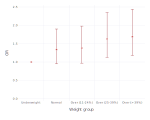

In [32]:
#| label: fig-fig1
#| fig-cap: "Effect of body weight on biopsy screening"
effect_plot(
  :Exposure, :OR, breast_df,
  xlab = "Weight group",
  ylab = "OR"
  )

::: callout-important
## Interpretation

The results show a constant increase in the odds ratios against the reference group, for each weight group. The linear increase is statistically significant (i.e., the slope is statistically different from zero) with a $p$ = 0.003.
:::

::: callout-note
The $p$-value came from the OR comparing *Over (> 39\%)* against *Underweight*. The actual $p$-value from the overal linear trend can be estimated from a logistic regression as shown bellow.
:::

In [33]:
coerce!(
	breast2,
	:Biopsy => Multiclass,
	:Weight => Multiclass
);

In [34]:
breast2.bio = [Biopsy == "Yes" ? 1.0 : 0.0 for Biopsy in breast2.Biopsy];

In [35]:
model = glm(@formula(bio ~ Weight), breast2, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

bio ~ 1 + Weight

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       z  Pr(>|z|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            -4.61714     0.171807  -26.87    <1e-99  -4.95387    -4.2804
Weight: Normal          0.294219    0.177389    1.66    0.0972  -0.0534573   0.641895
Weight: Over (11-24%)   0.323309    0.182024    1.78    0.0757  -0.0334523   0.680069
Weight: Over (25-39%)   0.49025     0.186277    2.63    0.0085   0.125153    0.855346
Weight: Over (> 39%)    0.527662    0.186077    2.84    0.0046   0.162958    0.892367
───────────────────────────────────────────────

In [36]:
anova(model)

Analysis of Variance

Type 1 test / Likelihood-ratio test

bio ~ 1 + Weight

Table:
──────────────────────────────────────────────────
             DOF  Deviance           χ²  Pr(>|χ²|)
──────────────────────────────────────────────────
(Intercept)    1  12940.40  109533.1636     <1e-99
Weight         4  12924.51      15.8930     0.0032
──────────────────────────────────────────────────

